In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix, make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.model_selection import ParameterGrid, GridSearchCV
from six import StringIO  
from IPython.display import Image  
import pydotplus
import pandas as pd
import graphviz 


In [2]:
df = pd.read_csv('./Data/diabetes_dataset.csv')
#Lấy và chia dữ liệu
x = df.drop(['Outcome'], axis=1)
y = df.Outcome


feature_name = df.columns[0:4]
target_name = ['0','1']



In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2)
#Chia thành 2 tập Test và Train
print("Training size: %d" %len(y_train))
print("Test size    : %d" %len(y_test))

Training size: 614
Test size    : 154


Kết quả sau khi Test: 68.18 %


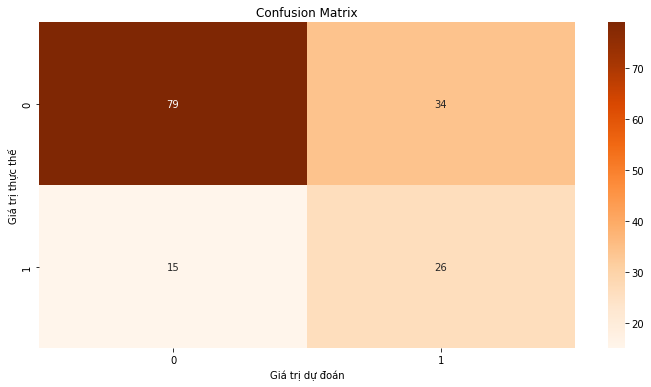

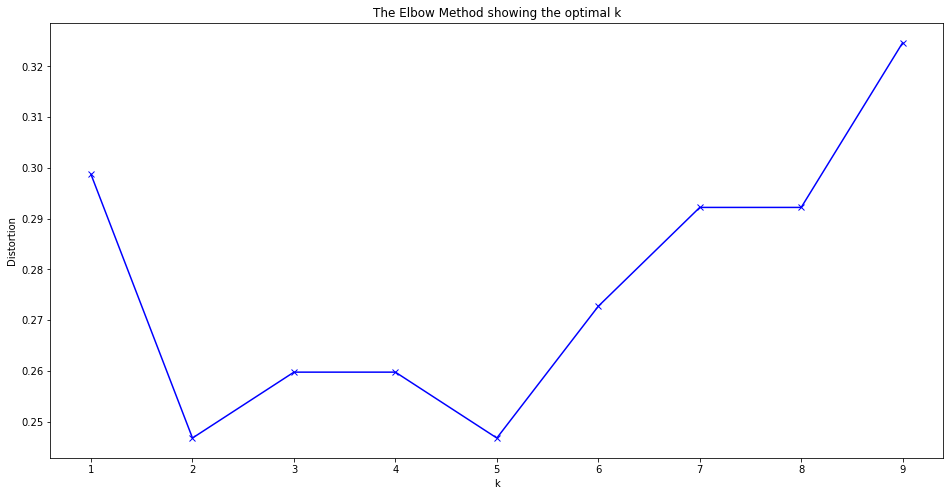

In [4]:
pipeline_dt = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=4)),
                    ('dts', DecisionTreeClassifier())])
pipeline_dt.fit(X_train,y_train)
#Test
y_pred = pipeline_dt.predict(X_test)

print("Kết quả sau khi Test: %.2f %%" %(100*accuracy_score(y_true = y_test, y_pred=y_pred)))

def pre_processing(X_train, X_test):
    # X_train_new = X_train
    # X_test_new = X_test
    scaler = StandardScaler()
    pca = PCA(n_components=4)
    scaler.fit(X_train)
    X_train_new = scaler.transform(X_train)
    X_test_new = scaler.transform(X_test)
    pca.fit(X_train_new)
    X_train_new = pca.transform(X_train_new)
    X_test_new = pca.transform(X_test_new)
    return(X_train_new,X_test_new)
    
clf = DecisionTreeClassifier();
X_train_new , X_test_new =pre_processing(X_train, X_test)

clf.fit(X_train_new ,y_train)


#Confusion Matrix
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt='d', cmap='Oranges')
plt.ylabel("Giá trị thực thế")
plt.xlabel("Giá trị dự đoán")
plt.show()



#Eblow
distortions = []
K = range(1,10)
for k in K:
    trees = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=4)),
                    ('dts', DecisionTreeClassifier(max_depth= k))])
    trees.fit(X_train, y_train)
    pred_i = trees.predict(X_test)
    distortions.append(np.mean(pred_i != y_test))

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


    

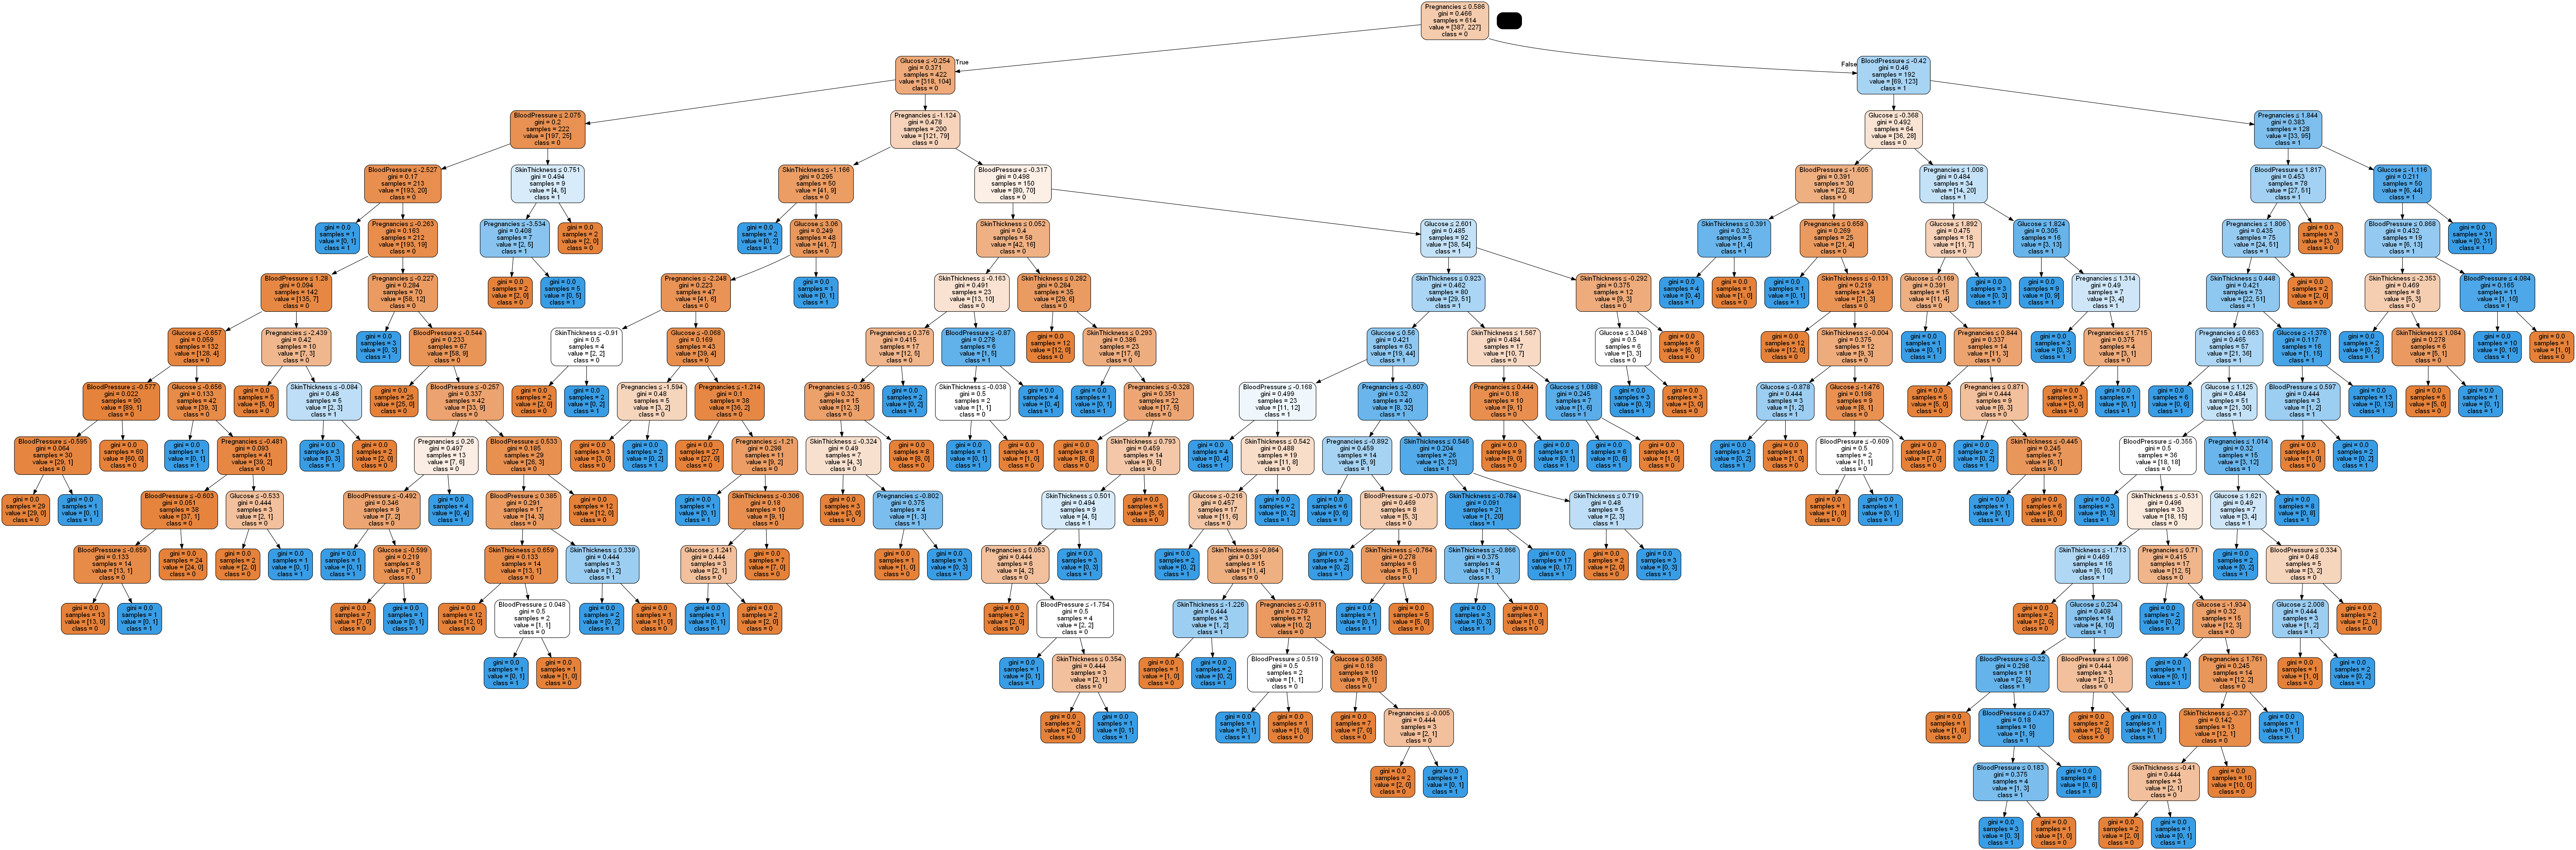

In [5]:
#Non-Pruning
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data, 
                     feature_names=feature_name,  
                     class_names=target_name,  
                     filled=True, rounded=True,  
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_png('./Result/non_pruning.png')
Image(graph.create_png())


Best max_depth: DecisionTreeClassifier(criterion='entropy', max_depth=2)


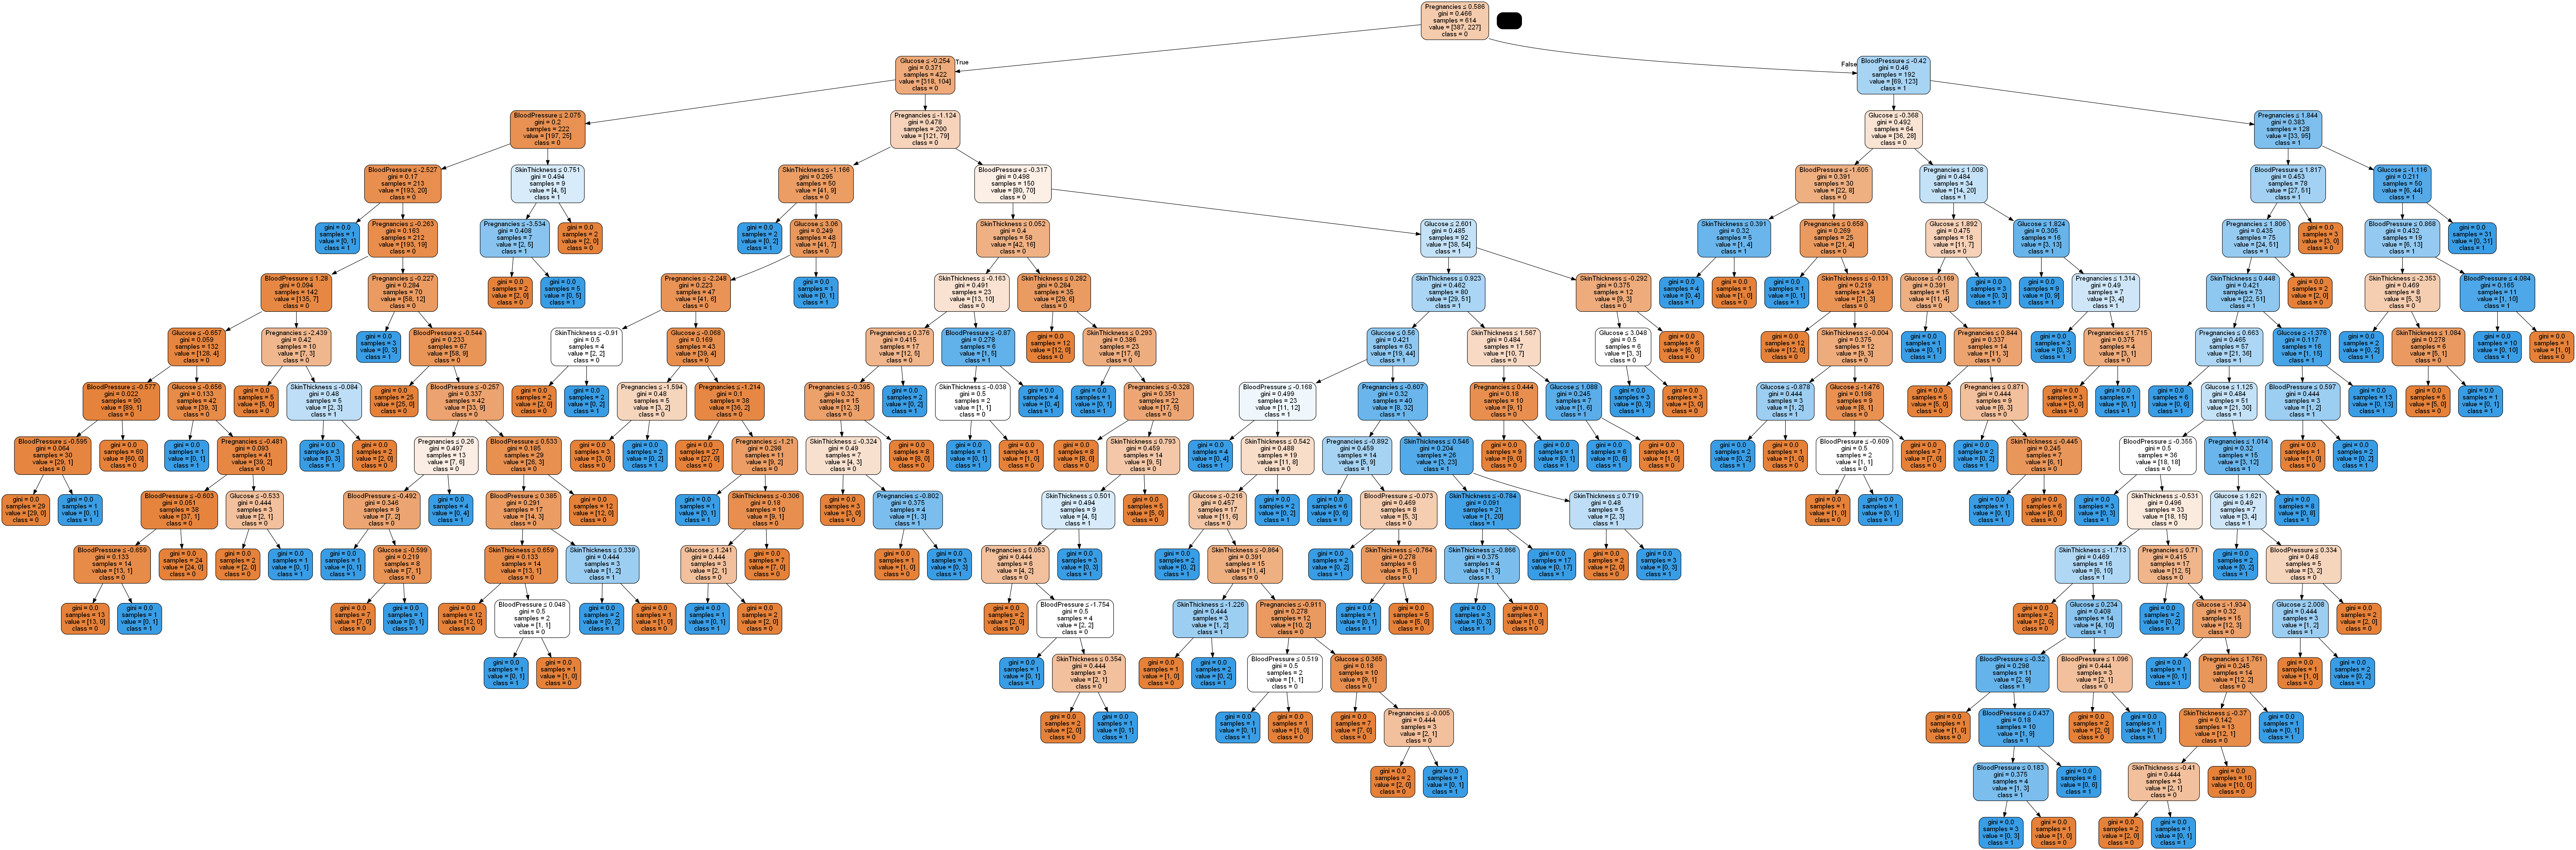

In [6]:
#Simple Pruning
max_depth = clf.get_depth()

max_depth_grid_search = GridSearchCV(
    estimator = DecisionTreeClassifier(criterion = "entropy"),
    scoring = make_scorer(accuracy_score),
    param_grid= ParameterGrid(
        {"max_depth": [[max_depth] for max_depth in range(1, max_depth +1)]}
    )
)

max_depth_grid_search.fit(X_train_new,y_train)


best_max_depth_tree = max_depth_grid_search.best_estimator_
print('Best max_depth:',best_max_depth_tree) 
best_max_depth = best_max_depth_tree.get_depth()

dot_data_bef = StringIO()
tree.export_graphviz(best_max_depth_tree,
                     out_file=dot_data_bef, 
                     feature_names=feature_name,  
                     class_names=target_name,  
                     filled=True, rounded=True,  
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_png('./Result/simple_pruning.png')
Image(graph.create_png())

Best param:  {'ccp_alpha': 0.0}


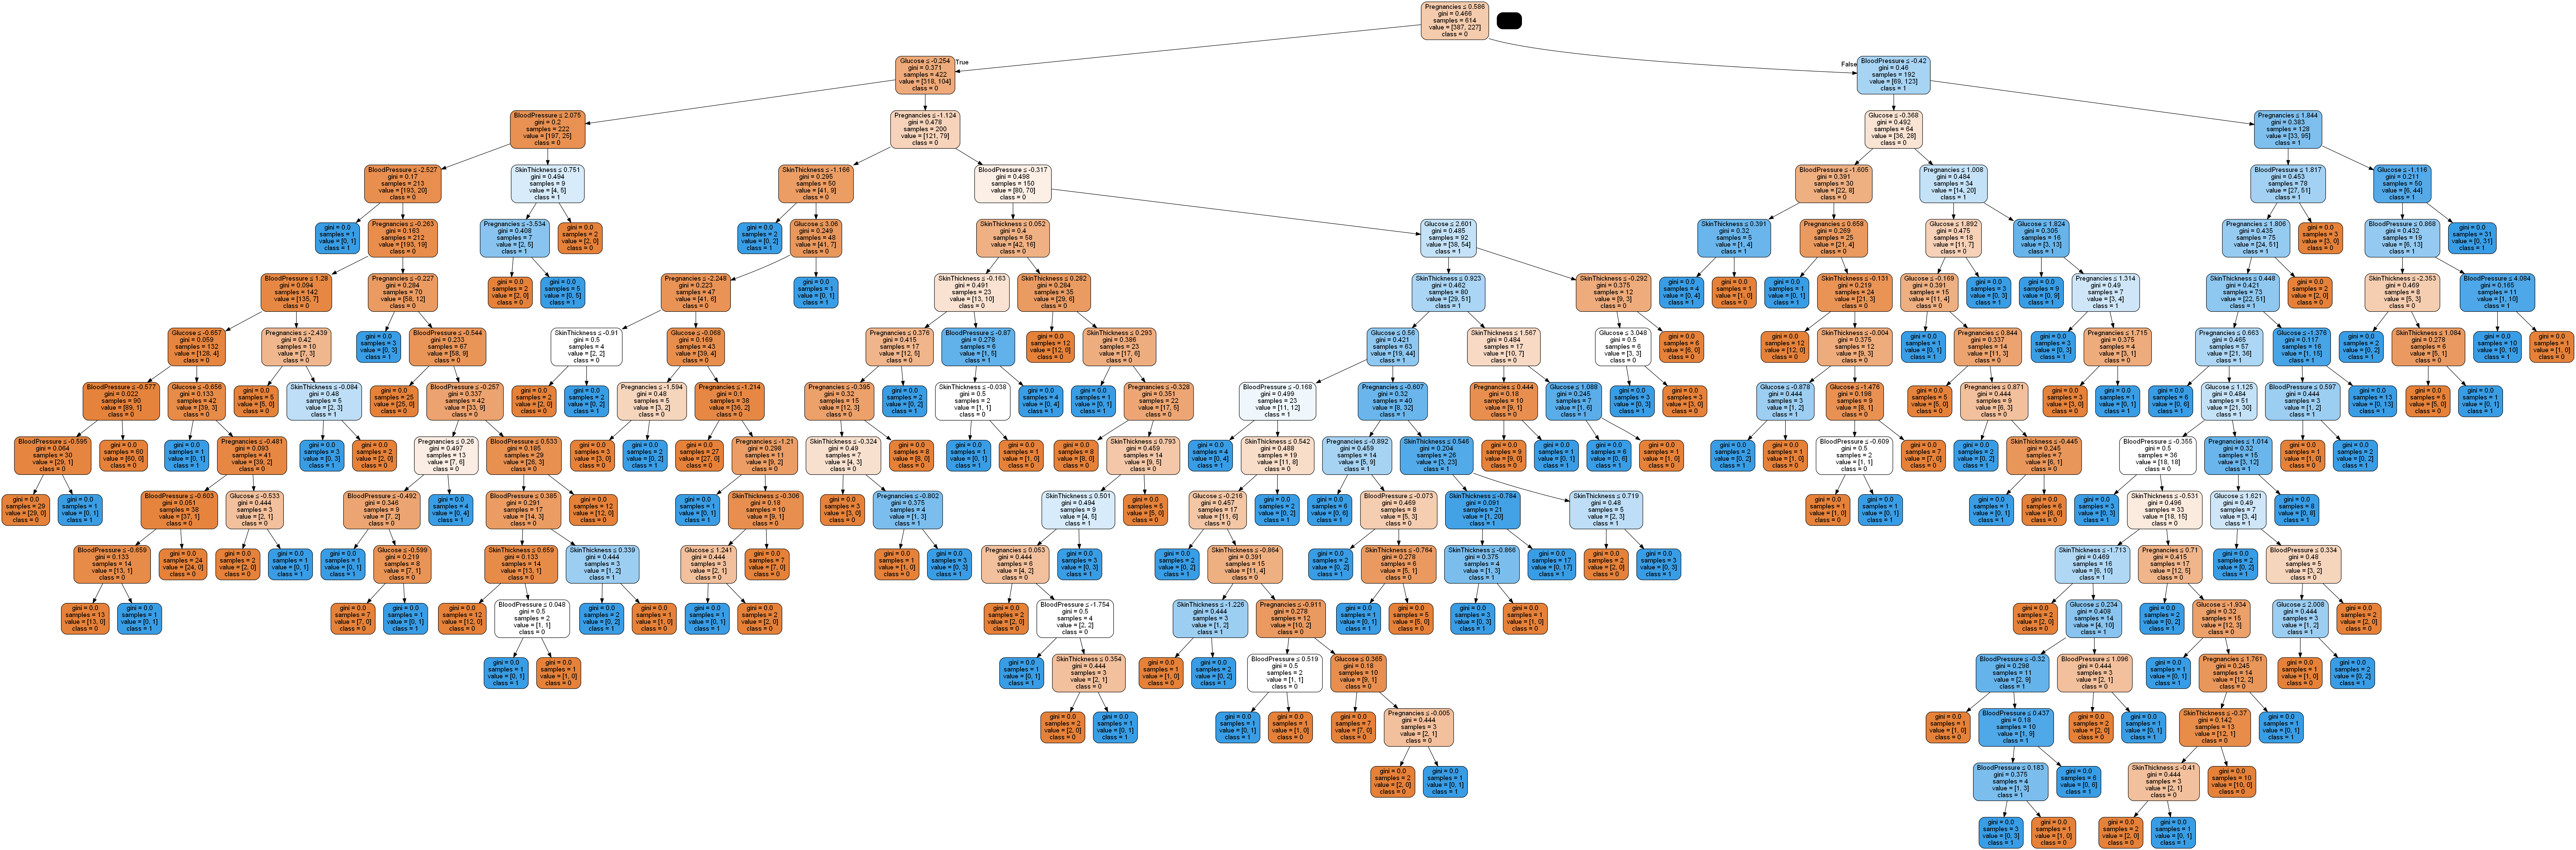

In [7]:
clf = DecisionTreeClassifier(criterion = "entropy", max_depth= best_max_depth)
clf.fit(X_train_new,y_train)

ccp_alphas = clf.cost_complexity_pruning_path(X_train,y_train)["ccp_alphas"]

ccp_alpha_grid_search = GridSearchCV(
    estimator = DecisionTreeClassifier(criterion = "entropy", max_depth= best_max_depth),
    scoring = make_scorer(accuracy_score),
    param_grid = ParameterGrid({"ccp_alpha": [[alpha] for alpha in ccp_alphas]}),
)

ccp_alpha_grid_search.fit(X_train_new,y_train)

print("Best param: ", ccp_alpha_grid_search.best_params_)

best_ccp_alphas_tree = ccp_alpha_grid_search.best_estimator_
dot_data_bef_2 = StringIO()
dot_data_bef_2 = tree.export_graphviz(best_ccp_alphas_tree,
                     out_file=None, 
                     feature_names=feature_name,  
                     class_names=target_name,  
                     filled=True, rounded=True,  
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_png('./Result/complexity_pruning.png')
Image(graph.create_png())


